# **PREDICTING BIRTH OUTCOMES FOLLOWING FERTILITY TREATMENT**

# **1. Set up and Loading the Anonymised Register**

In [ ]:
!pip install pyxlsb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Initialize the Javascript visualisation environment
shap.initjs()

In [ ]:
df = pd.read_excel("/content/sample_data/ar-2017-2018-xlsb.xlsb", sheet_name=1)

df.head()

,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,...,Heart three weeks gestation,Heart three birth outcome,Heart three birth weight,Heart three sex,Heart three birth congenital abnormalities,Heart three delivery date,Patient ethnicity,Partner ethnicity,Partner Type,Partner age
0,45-50,3,0,0.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Black,Other,Male,NaN
1,18-34,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,Other,NaN,NaN
2,999,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Other,Other,NaN,NaN
3,18-34,0,0,NaN,NaN,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,White,Male,18-34
4,18-34,1,0,NaN,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,White,Male,18-34


In [ ]:
# Standardise columns immediately after loading
df.columns = df.columns.str.lower().str.replace('[^a-z0-9_]+', '_', regex=True).str.strip('_')

In [ ]:
# Column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169616 entries, 0 to 169615
Data columns (total 61 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   patient_age_at_treatment                         169616 non-null  object 
 1   total_number_of_previous_ivf_cycles              169616 non-null  object 
 2   total_number_of_previous_di_cycles               169616 non-null  object 
 3   total_number_of_previous_pregnancies_ivf_and_di  42688 non-null   float64
 4   total_number_of_previous_live_births_ivf_or_di   105087 non-null  object 
 5   causes_of_infertility_tubal_disease              169616 non-null  int64  
 6   causes_of_infertility_ovulatory_disorder         169616 non-null  int64  
 7   causes_of_infertility_male_factor                169616 non-null  int64  
 8   causes_of_infertility_patient_unexplained        169616 non-null  int64  
 9   causes_of_infer

# **2. Data Cleaning and Pre-Processing**

**2.1 Drop Columns 38–57 (Foetal Heart & Birth Outcome Fields)**

Columns are 0-indexed, so 38–57 correspond to df.columns[37:57].

Since I do not need the columns with information on the foetal heart and birth outcomes fields, I decided to drop them

In [ ]:
# Identify columns to drop
cols_to_drop = df.columns[37:57]

# Drop them
df_reduced = df.drop(columns=cols_to_drop)

# Display summary
print({
    "original_shape": df.shape,
    "new_shape": df_reduced.shape,
    "dropped_columns": list(cols_to_drop)
})

{'original_shape': (169616, 61), 'new_shape': (169616, 41), 'dropped_columns': ['early_outcome', 'number_of_foetal_sacs_with_fetal_pulsation', 'heart_one_weeks_gestation', 'heart_one_birth_outcome', 'heart_one_birth_weight', 'heart_one_sex', 'heart_one_delivery_date', 'heart_one_birth_congenital_abnormalities', 'heart_two_weeks_gestation', 'heart_two_birth_outcome', 'heart_two_birth_weight', 'heart_two_sex', 'heart_two_delivery_date', 'heart_two_birth_congenital_abnormalities', 'heart_three_weeks_gestation', 'heart_three_birth_outcome', 'heart_three_birth_weight', 'heart_three_sex', 'heart_three_birth_congenital_abnormalities', 'heart_three_delivery_date']}


In [ ]:
# 3. Define the clinical logic function
def impute_history_based_on_cycles(df):
    """
    Automatically fills pregnancy and birth history with 0 if
    recorded previous cycles are 0.
    """
    # Use the cleaned column names here
    # We use df (the local variable) instead of df_reduced inside the function for better practice
    mask = (df['total_number_of_previous_ivf_cycles'] == 0) & \
           (df['total_number_of_previous_di_cycles'] == 0)

    targets = [
        'total_number_of_previous_pregnancies_ivf_and_di',
        'total_number_of_previous_live_births_ivf_or_di'
    ]

    # Fill with 0 where mask is True
    df.loc[mask, targets] = df.loc[mask, targets].fillna(0)

    return df

# 4. Execute function and display summary
df_reduced = impute_history_based_on_cycles(df_reduced)

print({
    "original_shape": df.shape,
    "new_shape": df_reduced.shape,
    "dropped_columns_count": len(cols_to_drop),
    "status": "Column names standardized and clinical logic applied"
})

{'original_shape': (169616, 61), 'new_shape': (169616, 41), 'dropped_columns_count': 20, 'status': 'Column names standardized and clinical logic applied'}


/tmp/ipython-input-3382975471.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[mask, targets] = df.loc[mask, targets].fillna(0)


In [ ]:
def impute_di_transfer_date(df):
    """
    Sets the date of embryo transfer to 0 if the
    Specific type of treatment is DI.
    """
    # 1. Create the condition for DI treatment
    # This assumes the column is standardized to 'specific_type_of_treatment'
    di_condition = df['specific_treatment_type'].astype(str).str.upper() == 'DI'

    # 2. Impute 0 into the target column for rows matching the condition
    # Targets the standardized 'date_of_embryo_transfer'
    df.loc[di_condition, 'date_of_embryo_transfer'] = 0

    return df

# Execute the function
df_reduced = impute_di_transfer_date(df_reduced)

# Verify the result for DI rows
print(df_reduced[df_reduced['specific_treatment_type'].astype(str).str.upper() == 'DI']['date_of_embryo_transfer'].unique())

[0.]


In [ ]:
# Drop rows where patient age is 999
df_reduced = df_reduced[df_reduced['patient_age_at_treatment'].astype(str) != '999']

# Verify the result
print(f"Remaining rows: {len(df_reduced)}")

Remaining rows: 166947


In [ ]:
# Drop the requested donor columns
donor_cols = ['egg_donor_age_at_registration', 'sperm_donor_age_at_registration']
df_reduced = df_reduced.drop(columns=donor_cols, errors='ignore')

# 5. SPECIFIC ROW DELETIONS (Targeting 999s and Blanks)
# Drop anything with 999 or '999' in patient_age and partner_age
for col in ['patient_age_at_treatment', 'partner_age']:
    df_reduced = df_reduced[~df_reduced[col].isin([999, '999'])]

# Drop 'nan', 'None', or blanks in partner_type
df_reduced['partner_type'] = df_reduced['partner_type'].astype(str).str.strip()
df_reduced = df_reduced[~df_reduced['partner_type'].isin(['nan', 'None', 'N/A', ''])]

# Final drop for any remaining blanks in the critical columns we discussed
final_na_drop = [
    'date_of_embryo_transfer',
    'total_number_of_previous_pregnancies_ivf_and_di',
    'partner_age',
    'partner_type'
]
df_reduced = df_reduced.dropna(subset=final_na_drop)

In [ ]:
# List of columns where we want to remove blank rows (NaNs)
cols_to_drop_blanks = [
    'date_of_embryo_transfer',
    'total_number_of_previous_pregnancies_ivf_and_di'
]

# Drop the rows
df_reduced = df_reduced.dropna(subset=cols_to_drop_blanks)

# Verify the final count
print(f"Rows remaining after final cleanup: {len(df_reduced)}")

Rows remaining after final cleanup: 75128


In [ ]:
# Missing Value Imputation (Filling NaNs)

# and df_reduced was created from df with original column names.
# This ensures that the column names used in subsequent steps (like `bit_cols`) match.
df_reduced.columns = df_reduced.columns.str.lower().str.replace('[^a-z0-9_]+', '_', regex=True).str.strip('_')

# Impute known Binary Indicators with 0 (Assuming NaN means 'Attribute Not Present')
bit_cols = [
    "frozen_cycle", "fresh_cycle", "elective_single_embryo_transfer",
    "donated_embryo",
    "embryos_transferred", "embryos_transferred_from_eggs_micro_injected",
]
df_reduced[bit_cols] = df_reduced[bit_cols].fillna(0).astype("int8")

# Explicitly impute '0' for object-type columns where NaN signifies 'none' or '0' count
# These columns will then be included in one-hot encoding as a '0' category
object_cols_to_fillna_0 = [
    "egg_source",
    "fresh_eggs_collected",
    "total_eggs_mixed",
    "total_embryos_created",
    "embryos_stored_for_use_by_patient",
]
for col in object_cols_to_fillna_0:
    if col in df_reduced.columns:
        df_reduced[col] = df_reduced[col].fillna('0')


# One-Hot Encoding (OHE) for remaining categorical features
cat_cols = df_reduced.select_dtypes(include=["object"]).columns.tolist()
df_model = pd.get_dummies(df_reduced, columns=cat_cols, drop_first=True) # drop_first=True avoids perfect multicollinearity

# Clean Column Names Post-Encoding (Removes symbols that break ML libraries)
df_model.columns = (
    df_model.columns
    .str.replace(r"[<>]", "", regex=True)
    .str.replace(r"[\[\]]", "", regex=True)
    .str.replace(" ", "_")
    .str.replace(r"\(", "", regex=True)
    .str.replace(r"\)", "", regex=True)
)

# C37: Convert residual Boolean columns to integer type
bool_cols = df_model.select_dtypes(include='bool').columns.tolist()
for col in bool_cols:
    df_model[col] = df_model[col].astype('int8')
    
# Serialisation fix for Arrow (convert mixed objects to string)
for col in df_reduced.select_dtypes(include=['object']).columns:
    df_reduced[col] = df_reduced[col].astype(str)
            
return df_raw, df_reduced

print("Data Cleaning and Encoding complete. Final features:", df_model.shape[1])

Data Cleaning and Encoding complete. Final features: 111


In [ ]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75128 entries, 3 to 169615
Data columns (total 39 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   patient_age_at_treatment                         75128 non-null  object 
 1   total_number_of_previous_ivf_cycles              75128 non-null  object 
 2   total_number_of_previous_di_cycles               75128 non-null  object 
 3   total_number_of_previous_pregnancies_ivf_and_di  75128 non-null  float64
 4   total_number_of_previous_live_births_ivf_or_di   75128 non-null  object 
 5   causes_of_infertility_tubal_disease              75128 non-null  int64  
 6   causes_of_infertility_ovulatory_disorder         75128 non-null  int64  
 7   causes_of_infertility_male_factor                75128 non-null  int64  
 8   causes_of_infertility_patient_unexplained        75128 non-null  int64  
 9   causes_of_infertility_endometrio

# **3. Exploratory Data Analysis (EDA)**


--- EDA: Missingness and Data Types ---
<class 'pandas.core.frame.DataFrame'>
Index: 75128 entries, 3 to 169615
Data columns (total 39 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   patient_age_at_treatment                         75128 non-null  object 
 1   total_number_of_previous_ivf_cycles              75128 non-null  object 
 2   total_number_of_previous_di_cycles               75128 non-null  object 
 3   total_number_of_previous_pregnancies_ivf_and_di  75128 non-null  float64
 4   total_number_of_previous_live_births_ivf_or_di   75128 non-null  object 
 5   causes_of_infertility_tubal_disease              75128 non-null  int64  
 6   causes_of_infertility_ovulatory_disorder         75128 non-null  int64  
 7   causes_of_infertility_male_factor                75128 non-null  int64  
 8   causes_of_infertility_patient_unexplained        75128 non-null  int6

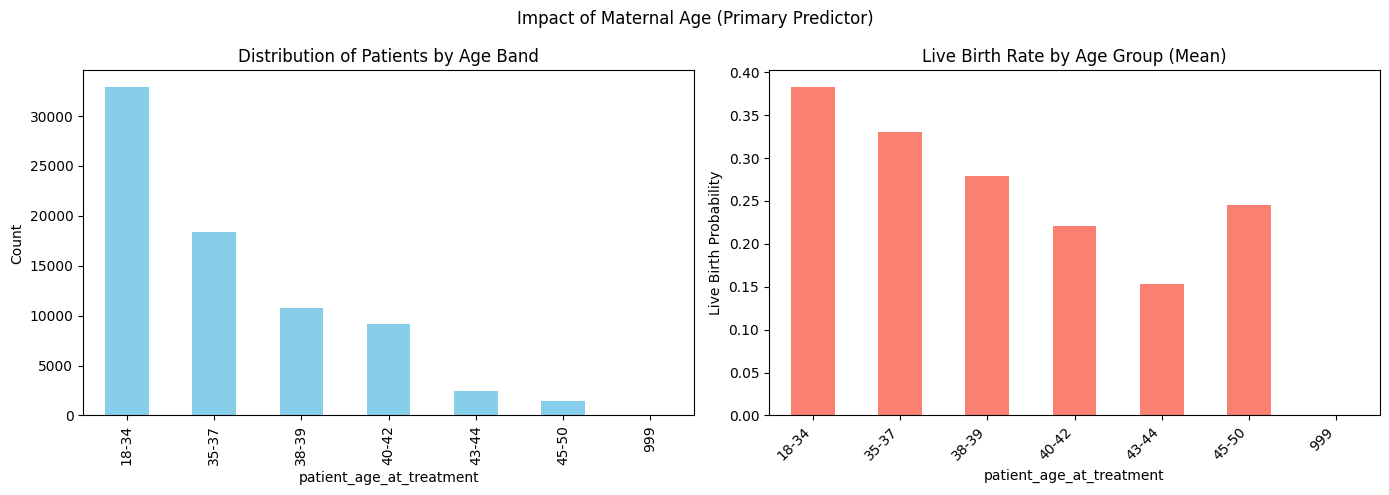

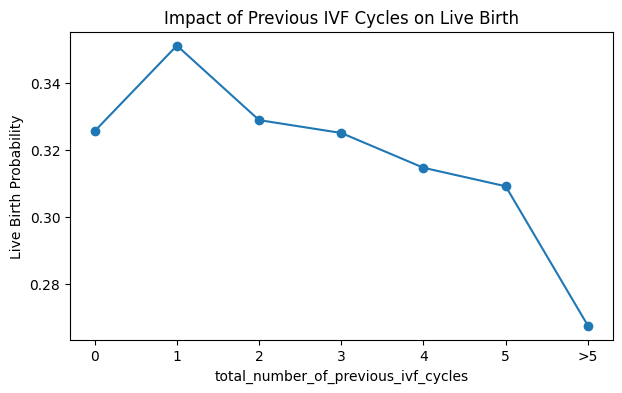

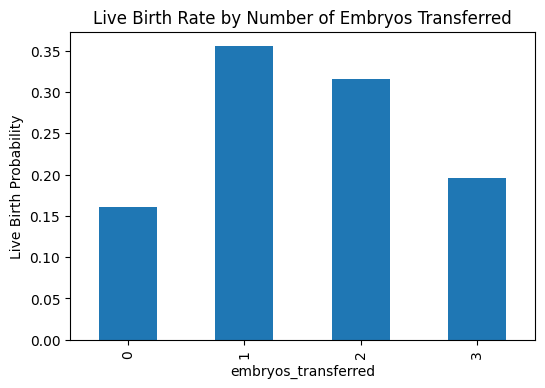

In [ ]:
# Initial Missingness Report (on final df_reduced features)
print("\n--- EDA: Missingness and Data Types ---")
print("Data Types:\n", df_reduced.info())
print("\nTop Missing Percentages (Before Modeling):")
print((df_reduced.isnull().mean() * 100).sort_values(ascending=False).head(10).to_markdown())


# Descriptive Statistics
print("\nDescriptive Statistics (Numerical):\n", df_reduced.describe().to_markdown())
print("\nDescriptive Statistics (Categorical):\n", df_reduced.describe(include="object").to_markdown())


# Overall Live Birth Rate (Key Metric)
live_birth_rate = df_reduced["live_birth_occurrence"].mean()
print(f"\nOverall Live Birth Rate: {live_birth_rate:.2%}")


# Live Birth Rate vs. Age Group (Confirming Literature's strongest factor)
age_counts = df_reduced['patient_age_at_treatment'].value_counts()
age_order = ["18-34", "35-37", "38-39", "40-42", "43-44", "45-50", "999"]
age_counts_ordered = age_counts.reindex(age_order)
age_livebirth = df_reduced.groupby("patient_age_at_treatment")["live_birth_occurrence"].mean().reindex(age_order)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

age_counts_ordered.plot(kind='bar', color='skyblue', ax=ax[0])
ax[0].set_title("Distribution of Patients by Age Band")
ax[0].set_ylabel("Count")

age_livebirth.plot(kind="bar", color="salmon", ax=ax[1])
ax[1].set_title("Live Birth Rate by Age Group (Mean)")
ax[1].set_ylabel("Live Birth Probability")

plt.suptitle("Impact of Maternal Age (Primary Predictor)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show() #


# Other Key Relationship Plots
df_reduced.groupby("total_number_of_previous_ivf_cycles")["live_birth_occurrence"].mean().plot(
    kind="line", marker="o", figsize=(7, 4)
)
plt.title("Impact of Previous IVF Cycles on Live Birth")
plt.ylabel("Live Birth Probability")
plt.show()

df_reduced.groupby("embryos_transferred")["live_birth_occurrence"].mean().plot(
    kind="bar", figsize=(6, 4)
)
plt.title("Live Birth Rate by Number of Embryos Transferred")
plt.ylabel("Live Birth Probability")
plt.show()

# **4. Modelling**

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# Data Split (X, y definition and train/test split)
# Dropping 'number_of_live_births' to prevent data leakage
X = df_model.drop(["live_birth_occurrence", "number_of_live_births"], axis=1, errors='ignore')
y = df_model["live_birth_occurrence"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # Stratify is critical for imbalanced data
)

# Test Set Alignment (Essential after One-Hot Encoding)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrame to maintain column names for tree-based models and LR
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Prepare numpy arrays from scaled data for XGBoost (if it prefers numpy input)
X_train_np = X_train_scaled_df.to_numpy()
y_train_np = y_train.to_numpy() # y doesn't need scaling
X_test_np_for_xgb = X_test_scaled_df.to_numpy()


#  Hyperparameter Tuning

# Random Forest Tuning
rf_params = {"n_estimators": [200, 300], "max_depth": [10, 15], "min_samples_split": [5, 10]}
rf_model = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_params, n_iter=5, cv=3, scoring="roc_auc", n_jobs=-1)
rf_search.fit(X_train_scaled_df, y_train) # Use scaled DataFrame
best_rf = rf_search.best_estimator_

# XGBoost Tuning
xgb_params = {"n_estimators": [300, 500], "max_depth": [6, 8], "learning_rate": [0.05, 0.1]}
xgb_model = XGBClassifier(random_state=42, eval_metric="logloss")

xgb_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, n_iter=5, cv=3, scoring="roc_auc", n_jobs=-1)
xgb_search.fit(X_train_np, y_train_np) # Use scaled NumPy arrays
best_xgb = xgb_search.best_estimator_

# Logistic Regression Tuning
log_params = {"C": [0.1, 1, 10], "penalty": ["l2"], "solver": ["lbfgs"]}
log_model = LogisticRegression(max_iter=1000) # Increased max_iter for safety, along with scaling
log_search = RandomizedSearchCV(estimator=log_model, param_distributions=log_params, n_iter=3, cv=3, scoring="roc_auc")
log_search.fit(X_train_scaled_df, y_train) # Use scaled DataFrame
best_lr = log_search.best_estimator_


# Final Model Evaluation
models = {"LR_Tuned": best_lr, "RF_Tuned": best_rf, "XGB_Tuned": best_xgb}
results = {}

print("\n--- Final Model Evaluation (Tuned Models) ---")
for name, model in models.items():
    if name == "XGB_Tuned":
        preds = model.predict(X_test_np_for_xgb)
        probs = model.predict_proba(X_test_np_for_xgb)[:,1]
    else:
        preds = model.predict(X_test_scaled_df)
        probs = model.predict_proba(X_test_scaled_df)[:,1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds),
        "AUC": roc_auc_score(y_test, probs)
    }

    print(f"\nModel: {name}")
    print(pd.DataFrame(results).T.loc[[name]].to_markdown())
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))


--- Final Model Evaluation (Tuned Models) ---

Model: LR_Tuned
|          |   Accuracy |   F1 Score |      AUC |
|:---------|-----------:|-----------:|---------:|
| LR_Tuned |   0.672301 |   0.225055 | 0.655654 |
Confusion Matrix:
 [[9387  752]
 [4172  715]]

Model: RF_Tuned
|          |   Accuracy |   F1 Score |      AUC |
|:---------|-----------:|-----------:|---------:|
| RF_Tuned |   0.675296 |  0.0816864 | 0.654511 |
Confusion Matrix:
 [[9930  209]
 [4670  217]]

Model: XGB_Tuned
|           |   Accuracy |   F1 Score |      AUC |
|:----------|-----------:|-----------:|---------:|
| XGB_Tuned |   0.676428 |    0.26467 | 0.658663 |
Confusion Matrix:
 [[9289  850]
 [4012  875]]


# **5. Interpretability and Persistence**

This phase achieves your key objective of model interpretability using the best performing model.


--- SHAP Interpretability: Beeswarm Plot ---


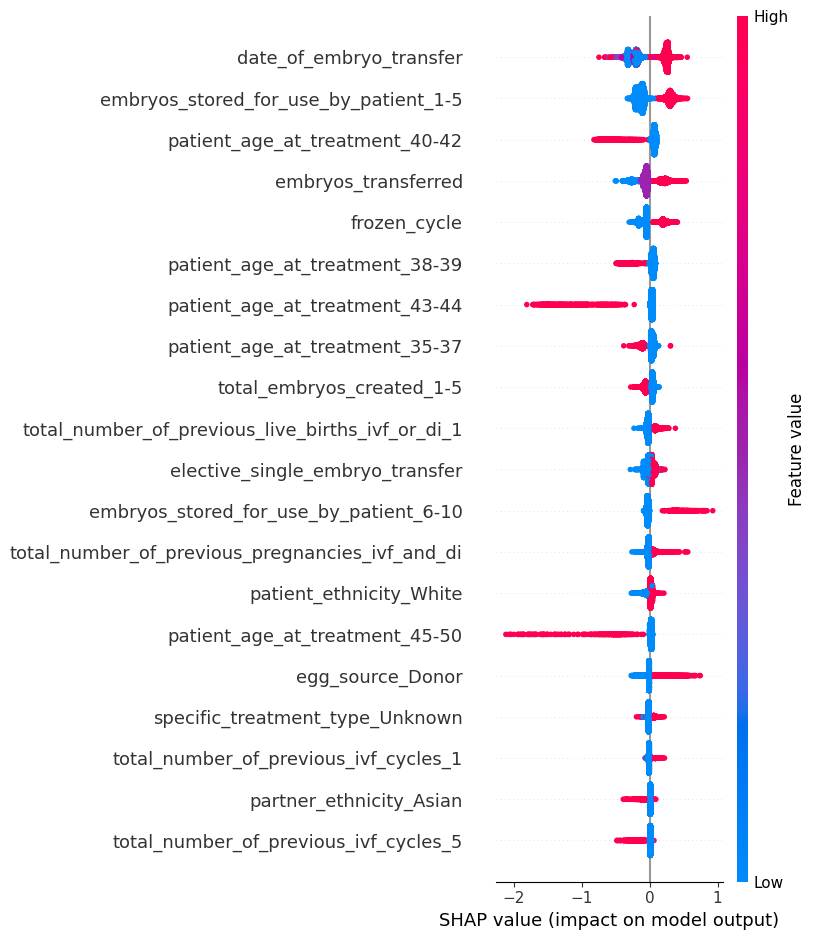


--- SHAP Interpretability: Bar Plot ---


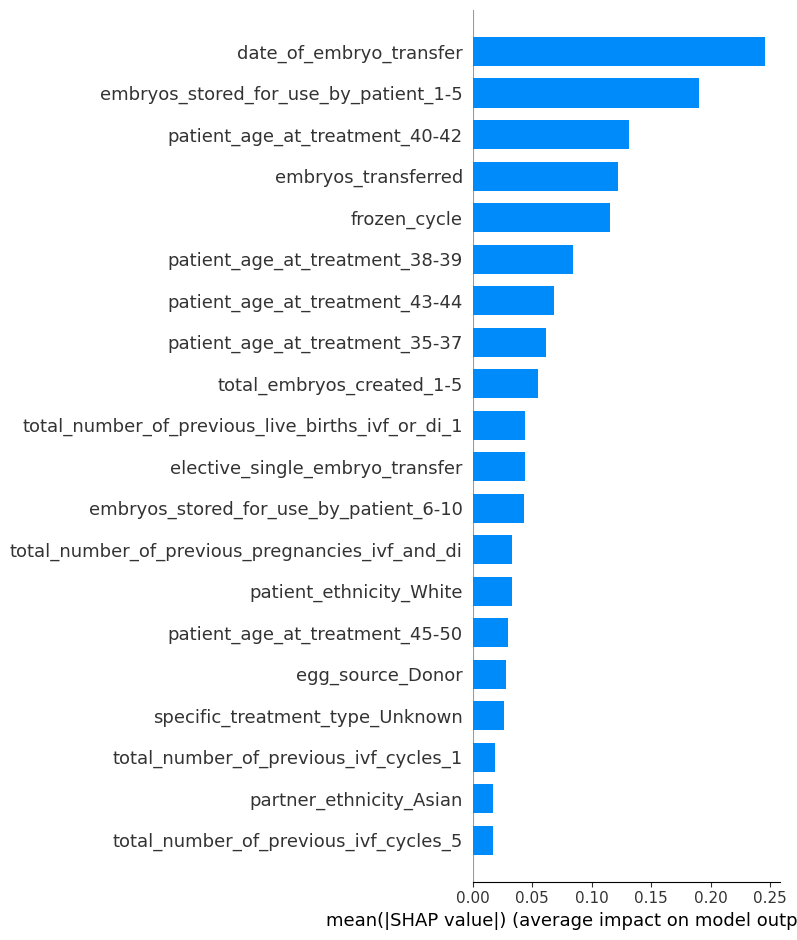


--- SHAP Force Plot for Row 10 ---

Best XGBoost model saved and successfully loaded.


In [ ]:
import pickle

# SHAP Explainer Setup (Using the best model from tuning)
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_np_for_xgb)


# SHAP Global Summary Plot (Beeswarm - Shows feature impact magnitude and direction)
print("\n--- SHAP Interpretability: Beeswarm Plot ---")
shap.summary_plot(shap_values, X_test, max_display=20) #


# SHAP Global Bar Plot (Average Importance)
print("\n--- SHAP Interpretability: Bar Plot ---")
shap.summary_plot(shap_values, X_test, plot_type="bar")


# SHAP Force Plot (Individual Prediction Explanation)
i = 10  # Example row (you can change this index)
print(f"\n--- SHAP Force Plot for Row {i} ---")
# Requires running shap.initjs() at the start of the notebook
shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i])


# Model Persistence (Saving the final, best model)
with open("best_xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

with open("best_xgb_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("\nBest XGBoost model saved and successfully loaded.")

# **VISUALISATIONS**

**C.1 Live Birth Rate by Age Band**

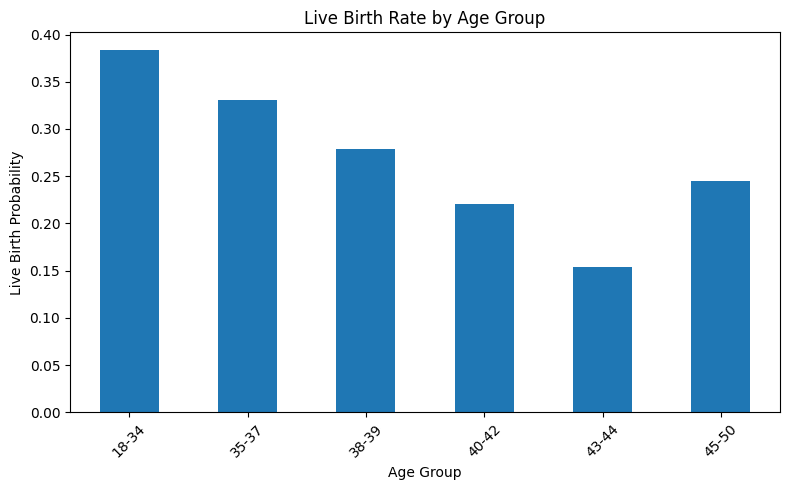

In [ ]:
age_livebirth = df_reduced.groupby("patient_age_at_treatment")["live_birth_occurrence"].mean()

plt.figure(figsize=(8,5))
age_livebirth.plot(kind="bar")
plt.title("Live Birth Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Live Birth Probability")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**C.2 Previous IVF Cycles vs Live Birth**

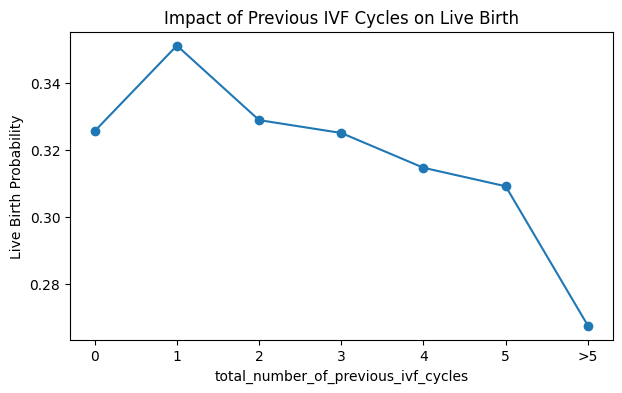

In [ ]:
df_reduced.groupby("total_number_of_previous_ivf_cycles")["live_birth_occurrence"].mean().plot(
    kind="line", marker="o", figsize=(7,4)
)
plt.title("Impact of Previous IVF Cycles on Live Birth")
plt.ylabel("Live Birth Probability")
plt.show()

**C.3 Embryos Transferred vs Live Birth**

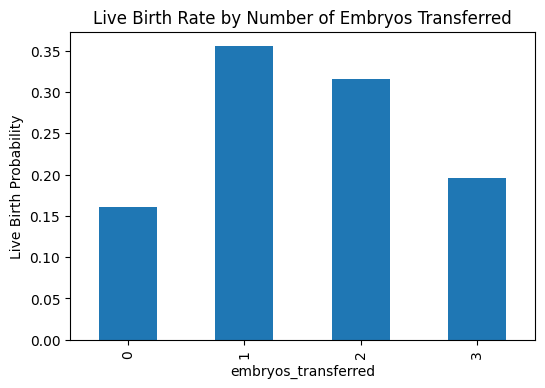

In [ ]:
df_reduced.groupby("embryos_transferred")["live_birth_occurrence"].mean().plot(
    kind="bar", figsize=(6,4)
)
plt.title("Live Birth Rate by Number of Embryos Transferred")
plt.ylabel("Live Birth Probability")
plt.show()

**C.4 Heatmap**

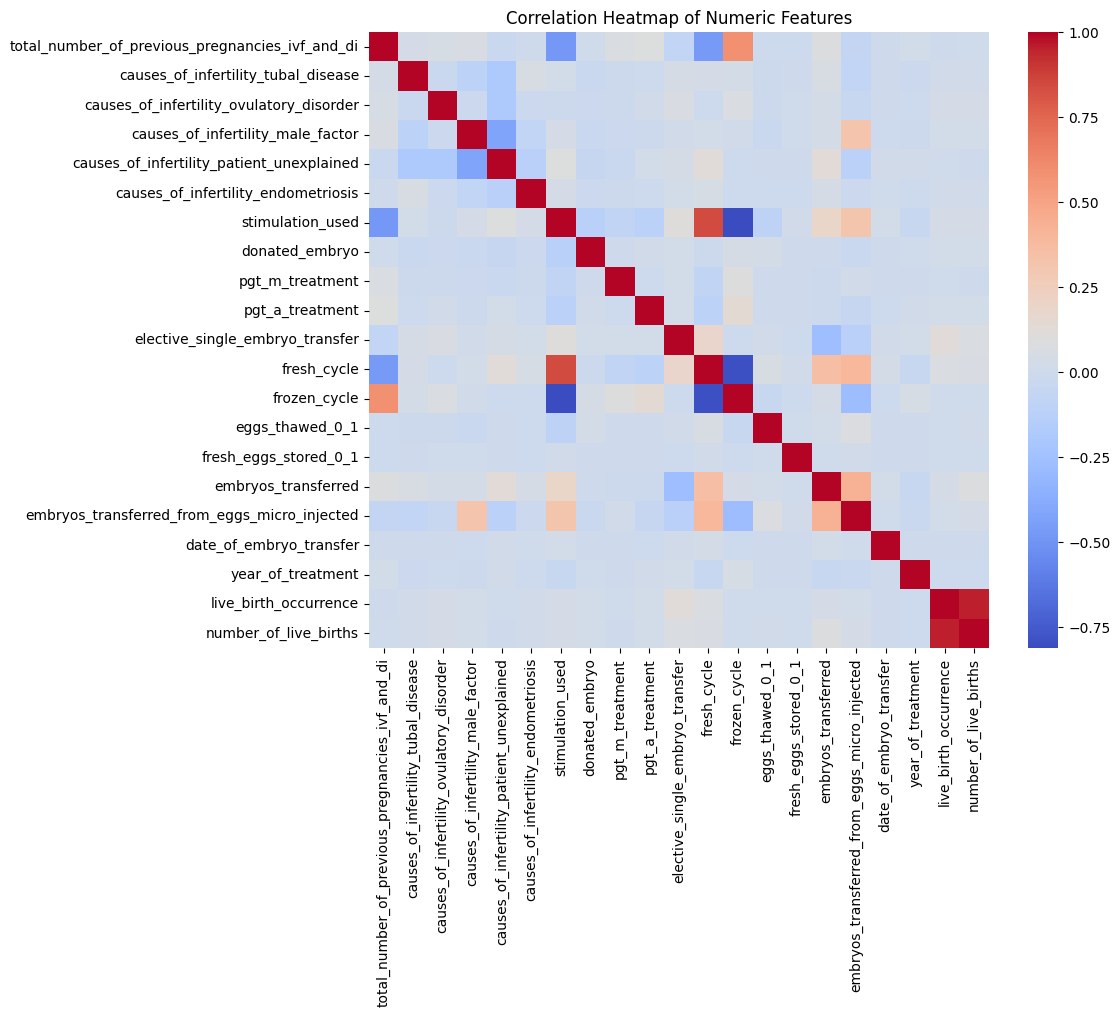

In [ ]:
import seaborn as sns
import numpy as np

# Select only numerical columns from df_reduced to create num_df
# This includes float64, int64, and int8 types
num_df = df_reduced.select_dtypes(include=np.number)

plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [ ]:
import pickle

# Save the trained model
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

# Save the scaler if you used one
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)